# Using Yahoo Finance to calc RSI and MFI

## Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf

In [56]:
candle_period = '1wk'
rolling_period = 14

## Get OHLCV

In [4]:
data = yf.download("SPY", interval = candle_period)

[*********************100%%**********************]  1 of 1 completed


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1.616000e+03
mean,170.661637,173.297585,167.923609,170.911785,142.532011,4.073519e+08
std,106.957537,108.548335,105.453779,107.233516,113.068925,4.315533e+08
min,43.343750,43.968750,42.812500,43.562500,24.628666,1.022000e+05
25%,105.296875,107.615002,103.154688,105.572500,70.726854,4.792588e+07
50%,132.000000,134.178749,129.635002,132.019997,93.450729,3.153046e+08
75%,210.430000,212.300003,207.884995,210.312500,180.937061,5.602494e+08
max,476.299988,479.980011,473.299988,475.309998,475.309998,3.281576e+09


In [8]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-11,459.690002,473.730011,459.470001,469.329987,467.434814,486953100
2023-12-18,470.980011,475.899994,467.820007,473.649994,473.649994,382852200
2023-12-25,474.070007,477.549988,473.299988,475.309998,475.309998,322779500
2024-01-01,472.160004,473.670013,466.429993,467.920013,467.920013,397502600
2024-01-08,468.429993,474.929993,468.299988,473.880005,473.880005,140670043


## RSI

In [11]:
data['Change'] = data['Adj Close'].diff()
data['Gain'] = data['Change'].mask(data['Change'] < 0, 0.0)
data['Loss'] = -data['Change'].mask(data['Change'] > 0, -0.0)

,Open,High,Low,Close,Adj Close,Volume,Change,Gain,Loss
Date,,,,,,,,,
2023-12-11,459.690002,473.730011,459.470001,469.329987,467.434814,486953100,9.093109,9.093109,0.000000
2023-12-18,470.980011,475.899994,467.820007,473.649994,473.649994,382852200,6.215179,6.215179,0.000000
2023-12-25,474.070007,477.549988,473.299988,475.309998,475.309998,322779500,1.660004,1.660004,0.000000
2024-01-01,472.160004,473.670013,466.429993,467.920013,467.920013,397502600,-7.389984,0.000000,7.389984
2024-01-08,468.429993,474.929993,468.299988,473.880005,473.880005,140670043,5.959991,5.959991,0.000000


In [12]:
def rma(x, n):
    """Running moving average"""
    a = np.full_like(x, np.nan)
    a[n] = x[1:n+1].mean()
    for i in range(n+1, len(x)):
        a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

In [28]:
data['Avg Gain'] = rma(data['Gain'].to_numpy(), rolling_period)
data['Avg Loss'] = rma(data['Loss'].to_numpy(), rolling_period)

In [29]:
data['RS'] = data['Avg Gain'] / data['Avg Loss']
data['RSI'] = 1 - (1 / (1 + data['RS']))
data.tail()

/home/andyw/.pyenv/versions/3.10.6/envs/rsi_mfi_notify/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


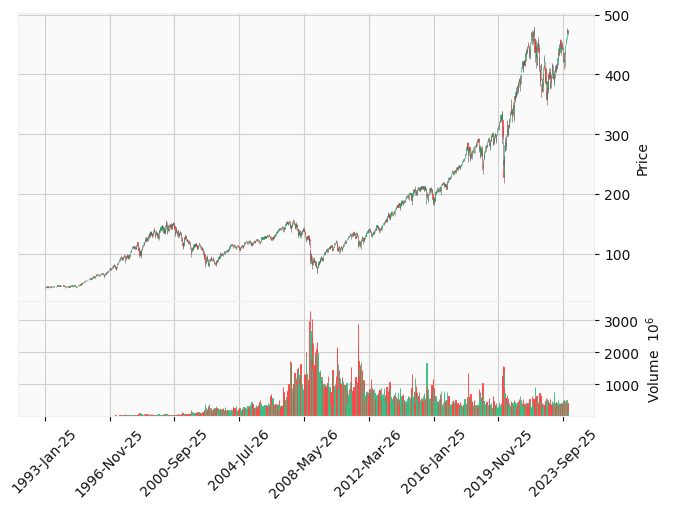

In [24]:
mpf.plot(data, type='candle', style='yahoo', volume=True)

<Axes: xlabel='Date'>

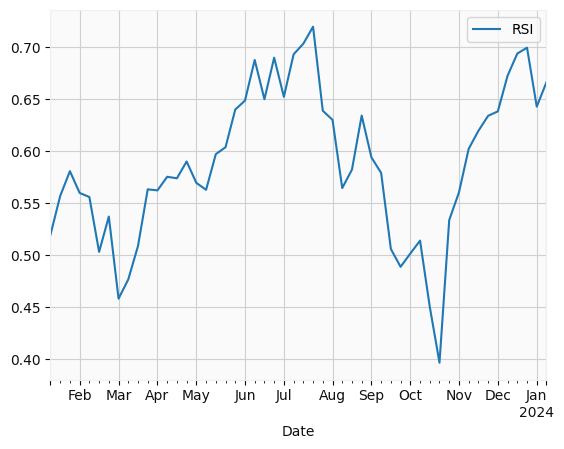

In [66]:
data[['RSI']].iloc[-52:].plot()

## MFI

In [26]:
data['Typical Price'] = (data['Adj Close'] + data['High'] + data['Low']) / 3
data['Money Flow'] = data['Typical Price'] * data['Volume']

In [35]:
def mf_dir(typical_price,money_flow):

    positive_flow = []
    negative_flow = []
    
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0)
            
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i-1])
            positive_flow.append(0)
            
        else:
            positive_flow.append(0)
            negative_flow.append(0)
            
    return positive_flow, negative_flow

In [46]:
data['Positive Flow'], data['Negative Flow'] = np.nan, np.nan

In [51]:
data['Positive Flow'].iloc[1:],data['Negative Flow'].iloc[1:] = mf_dir(data['Typical Price'].to_numpy(), data['Money Flow'].to_numpy())

/tmp/ipykernel_2083856/936769889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Positive Flow'].iloc[1:],data['Negative Flow'].iloc[1:] = mf_dir(data['Typical Price'].to_numpy(), data['Money Flow'].to_numpy())
/tmp/ipykernel_2083856/936769889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Positive Flow'].iloc[1:],data['Negative Flow'].iloc[1:] = mf_dir(data['Typical Price'].to_numpy(), data['Money Flow'].to_numpy())


In [57]:
data['Positive MF'] = data['Positive Flow'].rolling(rolling_period).sum()
data['Negative MF'] = data['Negative Flow'].rolling(rolling_period).sum()

In [59]:
data['MFI'] = data['Positive MF']/ (data['Positive MF'] + data['Negative MF'])
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,Typical Price,Money Flow,Positive Flow,Negative Flow,Positive MF,Negative MF,MFI
Date,,,,,,,,,,,,,,,,,,,,
2023-12-11,459.690002,473.730011,459.470001,469.329987,467.434814,486953100,9.093109,9.093109,0.000000,4.611791,2.246205,2.053148,0.672469,466.878276,2.273478e+11,1.654608e+11,0.000000e+00,1.339345e+12,1.047910e+12,0.561040
2023-12-18,470.980011,475.899994,467.820007,473.649994,473.649994,382852200,6.215179,6.215179,0.000000,4.726319,2.085761,2.265992,0.693814,472.456665,1.808811e+11,2.273478e+11,0.000000e+00,1.566693e+12,9.330433e+11,0.626743
2023-12-25,474.070007,477.549988,473.299988,475.309998,475.309998,322779500,1.660004,1.660004,0.000000,4.507296,1.936778,2.327213,0.699448,475.386658,1.534451e+11,1.808811e+11,0.000000e+00,1.747574e+12,7.626716e+11,0.696177
2024-01-01,472.160004,473.670013,466.429993,467.920013,467.920013,397502600,-7.389984,0.000000,7.389984,4.185346,2.326293,1.799148,0.642748,469.340007,1.865639e+11,0.000000e+00,1.534451e+11,1.747574e+12,7.381107e+11,0.703055
2024-01-08,468.429993,474.929993,468.299988,473.880005,473.880005,140670043,5.959991,5.959991,0.000000,4.312107,2.160129,1.996226,0.666247,472.369995,6.644831e+10,1.865639e+11,0.000000e+00,1.934138e+12,5.336508e+11,0.783753


<Axes: xlabel='Date'>

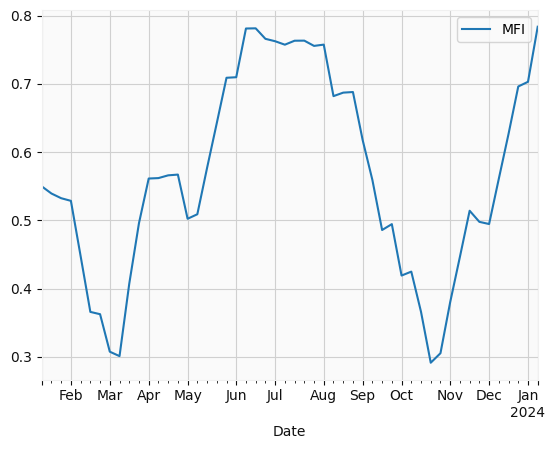

In [65]:
data[['MFI']].iloc[-52:].plot()